## Helper Functions for model traiinig 

In [32]:
import json
import pandas as pd
import collections
from sklearn.preprocessing import StandardScaler, LabelEncoder
from joblib import dump, load
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from tensorflow import keras
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB 

from sklearn.model_selection import train_test_split
import logging
import importlib
import tensorflow as tf
import abc



BATCH_SIZE = 256
EPOCHS = 100
RANDOM_SEED = 42 



In [34]:
#Importing required packages.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import numpy as np
%matplotlib inline
from urllib.request import urlretrieve
import collections
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')


**Visualization using TSNE**

In [35]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
RANDOM_SEED = 42 

def tsne_scatter(features, labels, dimensions=2, save_as='graph_flooding.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)
    
    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))
    
    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Malcious'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Benign'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;


def visualize(df, dim):
  # dropping redundant columns
  df = df.drop(['No.', 'Time', 'Source'], axis=1)

  # splitting by class
  malcious = df[df.Label == 1]
  clean = df[df.Label == 0]

  # concatenate with fraud transactions into a single dataframe
  visualisation_initial = pd.concat([malcious, clean])
  column_names = list(visualisation_initial.drop('Label', axis=1).columns)

  # isolate features from labels 
  features, labels = visualisation_initial.drop('Label', axis=1).values, \
                   visualisation_initial.Label.values

  # visualisations
  sns.set(style='whitegrid', context='notebook')

  tsne_scatter(features, labels, dimensions=dim)

def line(name,sym="*"):
  return sym*(25-len(name)//2)



**Helper functions to train on multiple models**

In [36]:
def new_split_test_train(df):
  #Now seperate the dataset as response variable and feature variabes
  X = df.drop('Label', axis = 1)
  y = df['Label']

  #Train and Test splitting of data 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


  from sklearn.preprocessing import Normalizer, MinMaxScaler
  from sklearn.pipeline import Pipeline

  # configure our pipeline
  pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])


  # get normalization parameters by fitting to the training data
  pipeline.fit(X_train)
  pipeline.fit(X_test)

  # transform the training and validation data with these parameters
  # X_train = pipeline.transform(X_train)
  # X_test = pipeline.transform(X_test)

  # #Applying Standard scaling to get optimized result
  # sc = StandardScaler()
  # X_train = sc.fit_transform(X_train)
  # X_test = sc.fit_transform(X_test)
  return([X_train, X_test, y_train, y_test])


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB 
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report,confusion_matrix, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier


# Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression



plt.style.use('classic')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)


def train_on_classics(df):
  # SVC Model
  svc = SVC(random_state=42)
  # LogisticRegression Model
  lr = LogisticRegression()
  # Gaussian Naive Bayes Model
  bnb = BernoulliNB()
  # Train XGBoost Classifier
  xgbc = XGBClassifier(eval_metric="logloss", random_state=42)
  # Train LightGBM Classifier
  lgbmc = LGBMClassifier(random_state=42)
  # SGD
  sgd = SGDClassifier(penalty=None)
  #Random Forest
  rfc = RandomForestClassifier(n_estimators=200)

  models = {}
  # models['SVC']= svc
  models['LogisticRegression']= lr
  models['Naive Bayes Classifier']= bnb
  models['XGBoost Classifier']= xgbc
  models['LightGBM Classifier']= lgbmc
  models['Stocastic Gradient Decent']= sgd
  # models['Random Forest']= rfc

  split = new_split_test_train(df)
  X_train = split[0]
  X_test = split[1]
  y_train = split[2]
  y_test = split[3]

  preds={}
  for name in models:
      print("=====Training On {0}====".format(name))
      # create the RFE model and select best attributes
      rfe = RFE(models[name])
      rfe = rfe.fit(X_train, y_train)
      # summarize the selection of the attributes
      print(rfe.support_)
      print(rfe.ranking_)
      #feed only selected features by RFE    
      models[name].fit(X_train.iloc[:, rfe.support_], y_train)
      print("====={0} model finished training====".format(name))
      preds[name] = models[name].predict(X_test.iloc[:, rfe.support_])
  print("Predictions complete.")

  target_names=["benign","malcious"]
  for name in models:
      print(line(name), name, 'Model Testing', line(name))
      #print(confusion_matrix(y_test, preds[name]))
      print(line(name,'-'))
      print(classification_report(y_test, preds[name], target_names=target_names))

  f1s = {"type":"F1-scores"}
  recall = {"type": "Recall"}
  precision = {"type": "Precision"}
  for name in models:
      f1s[name]=f1_score(y_test, preds[name])*100
      recall[name] = recall_score(y_test, preds[name])*100
      precision[name] = precision_score(y_test, preds[name])*100


  dfs = pd.DataFrame([recall, precision])
  dfs.set_index('type', inplace=True, drop=True)
  dfs.transpose().plot(kind = "bar",  ylim=[0,100], figsize=(20,6), rot=0)
  plt.legend(loc=(1.04, 1))


def downsample(df):
  df = df.drop(['No.', 'Time', 'Source'], axis=1)
  # Let's view the data.
  print("Training data has {} rows & {} columns".format(df.shape[0],df.shape[1])) 
  print(df['Label'].value_counts())

  print("Down sampling...!!")

  # Separate majority and minority classes
  df_minority = df[df.Label==0]
  df_majority = df[df.Label==1]
  
  # Downsample majority class
  df_majority_downsampled = resample(df_majority, 
                                  replace=False,    # sample without replacement
                                  n_samples=149833,     # to match minority class
                                  random_state=123) # reproducible results
  
  # Combine minority class with downsampled majority class
  df_downsampled = pd.concat([df_majority_downsampled, df_minority])
  
  # Display new class counts
  df_downsampled['Label'].value_counts()

  df = df_downsampled

  return df

# **Hello Flood Attack**

**Train Test Set Splitting**

In [37]:
# df1 = pd.read_csv('/content/drive/My Drive/phd-data/IRAD/hf-attack/HF10mix.csv')
# df2 = pd.read_csv('/content/drive/My Drive/phd-data/IRAD/hf-attack/HF20mix.csv')
# df3 = pd.read_csv('/content/drive/My Drive/phd-data/IRAD/hf-attack/HF100mix.csv')
# df4 = pd.read_csv('/content/drive/My Drive/phd-data/IRAD/hf-attack/HF1000mix.csv')
# # df5 = pd.read_csv('/content/drive/My Drive/phd-data/IRAD/benign/20Benign.csv').sample(n=5000)
# # df6 = pd.read_csv('/content/drive/My Drive/phd-data/IRAD/benign/100Benign.csv').sample(n=5000)
# df7 = pd.read_csv('/content/drive/My Drive/phd-data/IRAD/benign/1000Benign.csv')

# frames = [df1, df2, df3, df4, df7]
# df = pd.concat(frames) 
# print(df['Label'].value_counts())

# training_size1 = int(df1.shape[0] * 0.7)
# training_size2 = int(df2.shape[0] * 0.7)
# training_size3 = int(df3.shape[0] * 0.7)


# df1_training = df1.sample(n=training_size1)
# df1_testing = pd.concat([df1, df1_training]).drop_duplicates(keep=False)
# df2_training = df2.sample(n=training_size2)
# df2_testing = pd.concat([df2, df2_training]).drop_duplicates(keep=False)
# df3_training = df3.sample(n=training_size3)
# df3_testing = pd.concat([df3, df3_training]).drop_duplicates(keep=False)


# df1_training.to_csv('/content/drive/My Drive/phd-data/IRAD/hf-attack/HF10_training.csv', sep=',')
# df1_testing.to_csv('/content/drive/My Drive/phd-data/IRAD/hf-attack/HF10_testing.csv', sep=',')
# df2_training.to_csv('/content/drive/My Drive/phd-data/IRAD/hf-attack/HF20_training.csv', sep=',')
# df2_testing.to_csv('/content/drive/My Drive/phd-data/IRAD/hf-attack/HF20_testing.csv', sep=',')
# df3_training.to_csv('/content/drive/My Drive/phd-data/IRAD/hf-attack/HF100_training.csv', sep=',')
# df3_testing.to_csv('/content/drive/My Drive/phd-data/IRAD/hf-attack/HF100_testing.csv', sep=',')
# df4_training.to_csv('/content/drive/My Drive/phd-data/IRAD/hf-attack/HF1000_training.csv', sep=',')
# df4_testing.to_csv('/content/drive/My Drive/phd-data/IRAD/hf-attack/HF1000_testing.csv', sep=',')

**Loading data and visualizing**

In [38]:
df1_training = pd.read_csv('IRAD/hf-attack/HF10_training.csv')
df2_training = pd.read_csv('IRAD/hf-attack/HF20_training.csv')
df3_training = pd.read_csv('IRAD/hf-attack/HF100_training.csv')
df4_training = pd.read_csv('IRAD/hf-attack/HF1000_training.csv')
# df4 = pd.read_csv('IRAD/benign/20Benign.csv').sample(n=5000)
# df5 = pd.read_csv('IRAD/benign/100Benign.csv').sample(n=5000)
df7 = pd.read_csv('IRAD/benign/1000Benign.csv')

frames = [df1_training, df2_training, df3_training, df4_training]
df = pd.concat(frames) 
df = df[['Source','TR','RR','TPC', 'RPC', 'TTT', 'TRT', 'TAT', 'RAT', 'DAO', 'DIS', 'DIO', 'Label']]


# visualize(df, 2)


### Train Test Split and Feature Selection

In [39]:
split = new_split_test_train(df)
X_train = split[0]
X_test = split[1]
y_train = split[2]
y_test = split[3]


# # Recursive Feature Elimination
# from sklearn import datasets
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
# # load the iris datasets

# # create a base classifier used to evaluate a subset of attributes
# model = LogisticRegression()
# # create the RFE model and select 3 attributes
# rfe = RFE(model)
# rfe = rfe.fit(X_train, y_train)
# # summarize the selection of the attributes
# print(rfe.support_)
# print(rfe.ranking_)
# rfe.support_.append(True)

# df.loc[:, rfe.support_]

# df.head()

**Training on multiple models**

=====Training On LogisticRegression====
[False False False  True False  True  True False False  True  True  True]
[5 4 7 1 6 1 1 2 3 1 1 1]
=====LogisticRegression model finished training====
=====Training On Naive Bayes Classifier====
[ True False False False False  True False  True False  True  True  True]
[1 7 6 5 4 1 3 1 2 1 1 1]
=====Naive Bayes Classifier model finished training====
=====Training On XGBoost Classifier====
[False False  True False False False  True  True  True False  True  True]
[4 3 1 7 6 5 1 1 1 2 1 1]
=====XGBoost Classifier model finished training====
=====Training On LightGBM Classifier====
[ True  True  True False False  True  True False  True False False False]
[1 1 1 7 6 1 1 4 1 2 5 3]
=====LightGBM Classifier model finished training====
=====Training On Stocastic Gradient Decent====
[False False False  True False False False  True  True  True  True  True]
[6 2 7 1 5 3 4 1 1 1 1 1]
=====Stocastic Gradient Decent model finished training====
Predictions comp

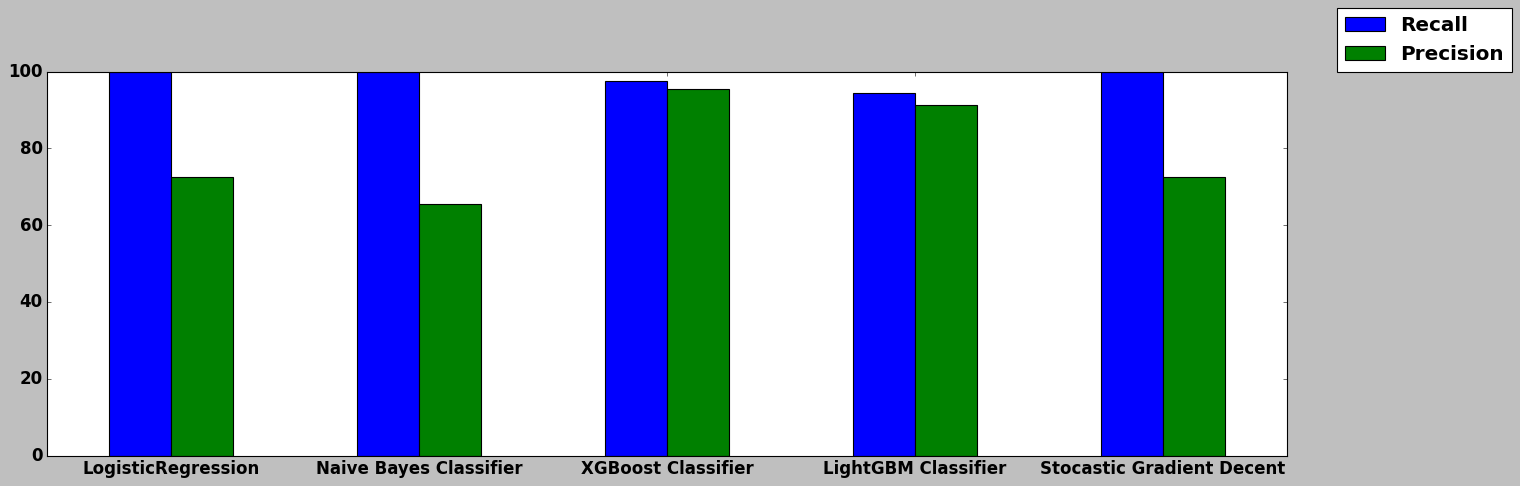

In [42]:
train_on_classics(df)

## Implemening the XGBoost model competible to plugin to the Framework

In [57]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report, confusion_matrix
from joblib import dump, load
from lightgbm import LGBMClassifier


class Model(metaclass=abc.ABCMeta):
  def __init__(self, modelname):
    self.model = ""
    self.model_name = modelname

  @abc.abstractmethod
  def test(self, df, malcious_ips):
    pass

  @abc.abstractmethod
  def train(self, df, window_size):
    pass

  @abc.abstractmethod
  def load_model(self, location):
    pass
  
  @abc.abstractmethod
  def predict(self, data_frame, window_size):
    pass

  def label_for_training(self, df, malcious_ips):
    #setting labels 
    df["label"] =  0

    for ips in malcious_ips:
      df.loc[df.src_ip == ips, 'label'] = 1

    return df

  @abc.abstractmethod
  def preprocess(self, df, window_size=1000):
    pass



class XGB(Model):
  def __init__(self, modelname):
    self.model = ""
    self.model_name = modelname

  def normalize(self, df):
    X = df.values
    pipeline = Pipeline([('normalizer', Normalizer()),('scaler', MinMaxScaler())])
    # get normalization parameters by fitting to the training data
    pipeline.fit(X)
    # X = pipeline.transform(X)

    return X

  def test(self, df):
    print("====Testing Started===")

    # preparing for for training
#     df = df.drop(['Source'], axis=1)

    y = df['Label']
    df = df.drop('Label', axis = 1)
  
    X = self.normalize(df)

    predictions = self.model.predict(X)
    #visualize confusion matrix 
    
    cf_matrix = confusion_matrix(y, predictions)
    target_names=["benign","malcious"]
    print(cf_matrix)
    print(classification_report(y, predictions, target_names=target_names))

  def train(self, df, window_size=1000):
    print("====Train Started===")

    # preparing for for training
    #   df = df.drop(['Source'], axis=1)

    split = self.split_test_train(df)
    X_train = split[0]
    X_test = split[1]
    y_train = split[2]
    y_test = split[3]

    #Let's run our SVC with the best parameters.
    #svc = SVC(C = 0.1, gamma =  0.1, kernel= 'linear')
    
    xgbc = XGBClassifier(eval_metric="logloss", random_state=42)
#     lgbmc = LGBMClassifier(random_state=42)
    xgbc.fit(X_train, y_train)

    predictions = xgbc.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, predictions)
    import seaborn as sns

    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

    ax.set_title('Confusion matrix');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Benign','Malicious'])
    ax.yaxis.set_ticklabels(['Benign','Malicious'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
    # print(sv2.predict(X_test))
    target_names=["benign","malcious"]
    print(classification_report(y_test, predictions, target_names=target_names))
    self.model = xgbc
    dump(xgbc, self.model_name+'.joblib')


  def load_model(self, location):
    print("====Model Loading=====")
    self.model = load(location) 

  def predict(self, df, window_size=1000):
    print("====Predicting========")
    src_ips = pd.DataFrame()
    src_ips = df[['Source']]
    df = df.drop(['Source'], axis=1)

    X = self.normalize(df)
    predictions = self.model.predict(X)

    return predictions
    # if len(predictions) != 0:
    #   src_ips[self.model_name] = predictions
    # return src_ips
  
  def preprocess(self, df, window_size):
    print("====Preprocessing=====")

  def downsample(self, df, majority_label, minority_label):
    # Let's view the data.
    print("Training data has {} rows & {} columns".format(df.shape[0],df.shape[1])) 
    print(df['Label'].value_counts())

    print("Down sampling...!!")

    # Separate majority and minority classes
    df_majority = df[df.Label==majority_label]
    df_minority = df[df.Label==minority_label]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                    replace=False,    # sample without replacement
                                    n_samples=df_majority.shape[0],     # to match minority class
                                    random_state=123) # reproducible results
    
    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    
    # Display new class counts
    df_downsampled['Label'].value_counts()

    df = df_downsampled

    return df

  def split_test_train(self, df, test_size=0.2):
    #Now seperate the dataset as response variable and feature variabes
    X = df.drop('Label', axis = 1)
    y = df['Label']

    #Train and Test splitting of data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 42)

    #Normalizing
    from sklearn.preprocessing import Normalizer, MinMaxScaler
    from sklearn.pipeline import Pipeline

    # configure our pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                      ('scaler', MinMaxScaler())])


    # get normalization parameters by fitting to the training data
    pipeline.fit(X_train)
    pipeline.fit(X_test)

    # transform the training and validation data with these parameters
    # X_train = pipeline.transform(X_train)
    # X_test = pipeline.transform(X_test)

    # #Applying Standard scaling to get optimized result
    # sc = StandardScaler()
    # X_train = sc.fit_transform(X_train)
    # X_test = sc.fit_transform(X_test)
    return([X_train, X_test, y_train, y_test])

**Training model on best performing classifier**

====Train Started===


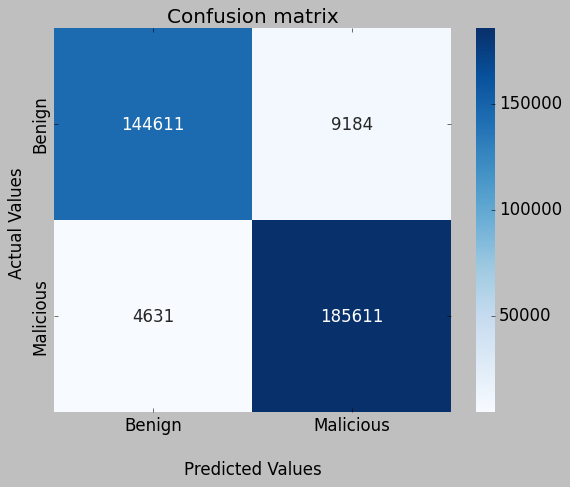

              precision    recall  f1-score   support

      benign       0.97      0.94      0.95    153795
    malcious       0.95      0.98      0.96    190242

    accuracy                           0.96    344037
   macro avg       0.96      0.96      0.96    344037
weighted avg       0.96      0.96      0.96    344037



In [58]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)


df1_training = pd.read_csv('IRAD/hf-attack/HF10_training.csv')
df2_training = pd.read_csv('IRAD/hf-attack/HF20_training.csv')
df3_training = pd.read_csv('IRAD/hf-attack/HF100_training.csv')
df4_training = pd.read_csv('IRAD/hf-attack/HF1000_training.csv')
# df4 = pd.read_csv('IRAD/benign/20Benign.csv').sample(n=5000)
# df5 = pd.read_csv('IRAD/benign/100Benign.csv').sample(n=5000)
df7 = pd.read_csv('IRAD/benign/1000Benign.csv')


frames = [df1_training, df2_training, df3_training, df4_training]
df = pd.concat(frames) 
df = df[['Source','TR','RR','TPC', 'RPC', 'TTT', 'TRT', 'TAT', 'RAT', 'DAO', 'DIS', 'DIO', 'Label']]

selected = [False, False,  True, False, False, False,  True,  True,  True, False,  True,  True, True]

# Features selected by RFE
df = df.loc[:, selected]


xgb = XGB('xgb_helloflood')
# df = lgmb.downsample(df,0, 1)


xgb.train(df)



**Model Testing**

In [59]:
xgb.load_model('xgb_helloflood.joblib')
df1_testing = pd.read_csv('IRAD/hf-attack/HF10_testing.csv')
df2_testing = pd.read_csv('IRAD/hf-attack/HF20_testing.csv')
df3_testing = pd.read_csv('IRAD/hf-attack/HF100_testing.csv')
df4_testing = pd.read_csv('IRAD/hf-attack/HF1000_testing.csv')
# df5 = pd.read_csv('IRAD/benign/20Benign.csv').sample(n=5000)
# df6 = pd.read_csv('IRAD/benign/100Benign.csv').sample(n=5000)
df7 = pd.read_csv('IRAD/benign/1000Benign.csv')

networks = {'HF 10 nodes':df1_testing, 'HF 20 nodes':df2_testing, 'HF 100 nodes':df3_testing, 'HF 1000 nodes':df4_testing}

for key,val in networks.items():
  df = val
  print("===={0}====".format(key))
  df = df[['Source','TR','RR','TPC', 'RPC', 'TTT', 'TRT', 'TAT', 'RAT', 'DAO', 'DIS', 'DIO', 'Label']]

  selected = [False, False,  True, False, False, False,  True,  True,  True, False,  True,  True, True]

  # Features selected by RFE
  df = df.loc[:, selected]
  xgb.test(df)

====Model Loading=====
====HF 10 nodes====
====Testing Started===
[[35912   176]
 [ 1785 28323]]
              precision    recall  f1-score   support

      benign       0.95      1.00      0.97     36088
    malcious       0.99      0.94      0.97     30108

    accuracy                           0.97     66196
   macro avg       0.97      0.97      0.97     66196
weighted avg       0.97      0.97      0.97     66196

====HF 20 nodes====
====Testing Started===
[[35977   175]
 [ 1041 30197]]
              precision    recall  f1-score   support

      benign       0.97      1.00      0.98     36152
    malcious       0.99      0.97      0.98     31238

    accuracy                           0.98     67390
   macro avg       0.98      0.98      0.98     67390
weighted avg       0.98      0.98      0.98     67390

====HF 100 nodes====
====Testing Started===
[[36148   180]
 [  956 30106]]
              precision    recall  f1-score   support

      benign       0.97      1.00      0.98  

## Posioning the model

In [20]:
df1_training = pd.read_csv('IRAD/hf-attack/HF10_training.csv')
df2_training = pd.read_csv('IRAD/hf-attack/HF20_training.csv')
df3_training = pd.read_csv('IRAD/hf-attack/HF100_training.csv')
df4_training = pd.read_csv('IRAD/hf-attack/HF1000_training.csv')
# df4 = pd.read_csv('IRAD/benign/20Benign.csv').sample(n=5000)
# df5 = pd.read_csv('IRAD/benign/100Benign.csv').sample(n=5000)
df7 = pd.read_csv('IRAD/benign/1000Benign.csv')


frames = [df1_training[0:10], df7]
df = pd.concat(frames) 
df = df[['Source','TR','RR','TPC', 'RPC', 'TTT', 'TRT', 'TAT', 'RAT', 'DAO', 'DIS', 'DIO', 'Label']]


lgmb = LGMB('lgmb_helloflood_poisoned')
# df = lgmb.downsample(df,0, 1)


lgmb.train(df)

====Train Started===
              precision    recall  f1-score   support

      benign       1.00      0.92      0.96    147783
    malcious       0.00      0.00      0.00         1

    accuracy                           0.92    147784
   macro avg       0.50      0.46      0.48    147784
weighted avg       1.00      0.92      0.96    147784



In [21]:
lgmb.load_model('lgmb_helloflood_poisoned.joblib')
df1_testing = pd.read_csv('IRAD/hf-attack/HF10_testing.csv')
df2_testing = pd.read_csv('IRAD/hf-attack/HF20_testing.csv')
df3_testing = pd.read_csv('IRAD/hf-attack/HF100_testing.csv')
df4_testing = pd.read_csv('IRAD/hf-attack/HF1000_testing.csv')
# df5 = pd.read_csv('IRAD/benign/20Benign.csv').sample(n=5000)
# df6 = pd.read_csv('IRAD/benign/100Benign.csv').sample(n=5000)
df7 = pd.read_csv('IRAD/benign/1000Benign.csv')

networks = {'HF 10 nodes':df1_testing, 'HF 20 nodes':df2_testing, 'HF 100 nodes':df3_testing, 'HF 1000 nodes':df4_testing}

for key,val in networks.items():
  df = val
  print("===={0}====".format(key))
  df = df[['Source','TR','RR','TPC', 'RPC', 'TTT', 'TRT', 'TAT', 'RAT', 'DAO', 'DIS', 'DIO', 'Label']]
  lgmb.test(df)

====Model Loading=====
====HF 10 nodes====
====Testing Started===
[[36088     0]
 [30108     0]]
              precision    recall  f1-score   support

      benign       0.55      1.00      0.71     36088
    malcious       0.00      0.00      0.00     30108

    accuracy                           0.55     66196
   macro avg       0.27      0.50      0.35     66196
weighted avg       0.30      0.55      0.38     66196

====HF 20 nodes====
====Testing Started===
[[36152     0]
 [31238     0]]
              precision    recall  f1-score   support

      benign       0.54      1.00      0.70     36152
    malcious       0.00      0.00      0.00     31238

    accuracy                           0.54     67390
   macro avg       0.27      0.50      0.35     67390
weighted avg       0.29      0.54      0.37     67390

====HF 100 nodes====
====Testing Started===
[[36328     0]
 [31062     0]]
              precision    recall  f1-score   support

      benign       0.54      1.00      0.70  